# BBC news articles classification

The purpose of this project is to develop a news article recommendation system. The system works as follows:
- A news article provided by the user is classified by an algorithm.
- Another algorithm looks for other similar articles belonging to the same class and provides a list of news articles ranked according to their similarity with the article provided by the user.

The purpose of this notebook is to develop the first part of this recommendation system: a model that classifies BBC news articles.  
  
The dataset used to that end is a public dataset named [BBC News Classification](https://kaggle.com/competitions/learn-ai-bbc).  
It's comprised of 2225 articles, each labeled under one of 5 categories: **business**, **entertainment**, **politics**, **sport or tech**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import string

import joblib

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marouan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data import and exploration

First of all, the data is imported in a pandas dataframe in order to facilitate data visualisation and processing.  
  
The data is already split into train and test dataset (test dataset is not labelled, it won't be used for training):
- 1490 articles for the train dataset.
- 735 articles for the test dataset.

### Data information

In [2]:
df_train = pd.read_csv("./data/BBC_News_Train.csv")
df_test = pd.read_csv("./data/BBC_News_Test.csv")

df_train.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


Here's an example of article.

In [5]:
df_train.iloc[0]["Text"]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

### Classes distribution

Count the number of articles for each class in order to detect possible imbalanced data.  
Imbalanced data could lead to bad results: the model is more likely to favor most represented classes over minority classes.
  
If the data is perfectly balanced, we should observe that each class represents 20% of the entire dataset.  
  

We observe that classes representation percentages range from 17.5% (minority class) to 23.2% (majority class).  
It's close to what we expect (20% for each class), therefore the dataset is not considered as imbalanced.

In [6]:
df_train["Category"].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

Compute the percentage corresponding to each class representation with respect to the entire dataset.

In [7]:
df_train["Category"].value_counts() / len(df_train) * 100

Category
sport            23.221477
business         22.550336
politics         18.389262
entertainment    18.322148
tech             17.516779
Name: count, dtype: float64

(array([336.,   0., 261.,   0.,   0., 274.,   0., 346.,   0., 273.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

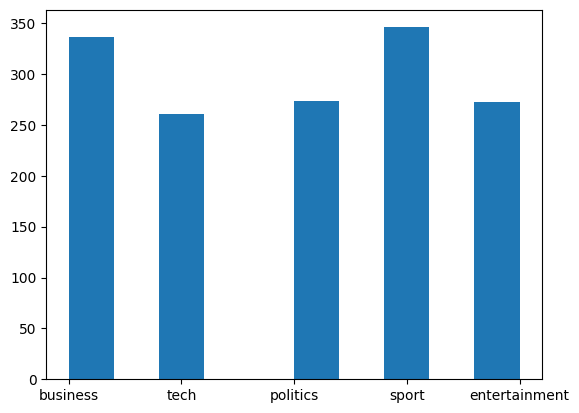

In [8]:
plt.hist(df_train["Category"])

## Preprocessing

It's important to perform the preprocessing on both training and test data since the model will be optimized to make inferences on preprocessed data.

#### Remove punctuation

In [3]:
punctuation = string.punctuation
df_train['Text'] = df_train['Text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]).split())
df_test['Text'] = df_test['Text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]).split())

In [6]:
df_train.iloc[0]["Text"]

['worldcom',
 'exboss',
 'launches',
 'defence',
 'lawyers',
 'defending',
 'former',
 'worldcom',
 'chief',
 'bernie',
 'ebbers',
 'against',
 'a',
 'battery',
 'of',
 'fraud',
 'charges',
 'have',
 'called',
 'a',
 'company',
 'whistleblower',
 'as',
 'their',
 'first',
 'witness',
 'cynthia',
 'cooper',
 'worldcom',
 's',
 'exhead',
 'of',
 'internal',
 'accounting',
 'alerted',
 'directors',
 'to',
 'irregular',
 'accounting',
 'practices',
 'at',
 'the',
 'us',
 'telecoms',
 'giant',
 'in',
 '2002',
 'her',
 'warnings',
 'led',
 'to',
 'the',
 'collapse',
 'of',
 'the',
 'firm',
 'following',
 'the',
 'discovery',
 'of',
 'an',
 '11bn',
 '£57bn',
 'accounting',
 'fraud',
 'mr',
 'ebbers',
 'has',
 'pleaded',
 'not',
 'guilty',
 'to',
 'charges',
 'of',
 'fraud',
 'and',
 'conspiracy',
 'prosecution',
 'lawyers',
 'have',
 'argued',
 'that',
 'mr',
 'ebbers',
 'orchestrated',
 'a',
 'series',
 'of',
 'accounting',
 'tricks',
 'at',
 'worldcom',
 'ordering',
 'employees',
 'to',
 'h

We observe that there are prepositions like "to", "at" or "of" that will not bring much value for the prediction. Let's remove them.

#### Remove stop words

In [4]:
stop_words = stopwords.words('english')

df_train['Text'] = df_train['Text'].apply(lambda x: ' '.join([i for i in x if i not in stop_words]))
df_test['Text'] = df_test['Text'].apply(lambda x: ' '.join([i for i in x if i not in stop_words]))

In [12]:
df_train.iloc[0]["Text"]

'worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant 2002 warnings led collapse firm following discovery 11bn £57bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates ms cooper runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom accounting early 2001 2002 said andersen given green light procedures practices used worldcom mr ebber lawyers said unaware fraud arguing auditors alert problems ms cooper also said shareholder meetings mr ebbers often passed technical questions company finance chief giving brief answers prosecution star witness

#### Lemmatization

Perform lemmatization to facilitate the semantic analysis.  
The WordNetLemmatizer is used. It's not necesarly the most efficient lemmatizer for this dataset since it's been built on WordNet dataset, but it still contributes to text normalization and semantic accuracy improvement (contrarly to stemming).

In [5]:
lemmatizer = WordNetLemmatizer()

df_train['Text'] = df_train['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df_test['Text'] = df_test['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [14]:
df_train.iloc[0]["Text"]

'worldcom exboss launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted director irregular accounting practice u telecom giant 2002 warning led collapse firm following discovery 11bn £57bn accounting fraud mr ebbers pleaded guilty charge fraud conspiracy prosecution lawyer argued mr ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings estimate m cooper run consulting business told jury new york wednesday external auditor arthur andersen approved worldcom accounting early 2001 2002 said andersen given green light procedure practice used worldcom mr ebber lawyer said unaware fraud arguing auditor alert problem m cooper also said shareholder meeting mr ebbers often passed technical question company finance chief giving brief answer prosecution star witness former worldcom financial c

## Classification model (Count vectorizer + Tfidf)

### Split data

In [9]:
X = df_train["Text"]
y = df_train["Category"]

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

### SVC model

#### Training

In [16]:
preprocessor = Pipeline(
    steps=[
        ('count_vect', CountVectorizer()), 
        ('tfidf', TfidfTransformer())
        ]
)

# Using a Pipeline to automate preprocessing and training
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC(random_state=42))]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('count_vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('classifier', SVC(random_state=42))])

#### Evaluation

Confusion matrix

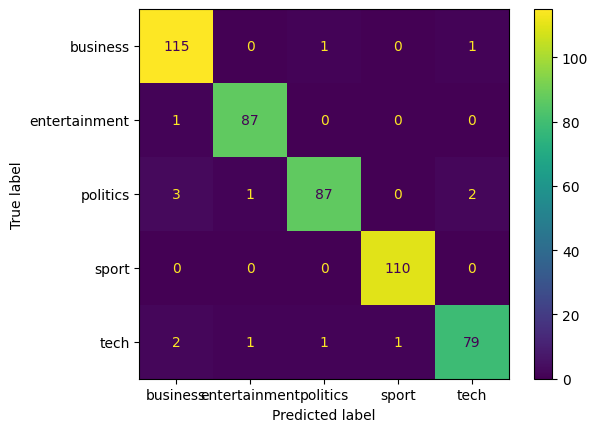

In [17]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Classification report

In [18]:
print(classification_report(y_test, predictions))

               precision    recall  f1-score   support

     business       0.95      0.98      0.97       117
entertainment       0.98      0.99      0.98        88
     politics       0.98      0.94      0.96        93
        sport       0.99      1.00      1.00       110
         tech       0.96      0.94      0.95        84

     accuracy                           0.97       492
    macro avg       0.97      0.97      0.97       492
 weighted avg       0.97      0.97      0.97       492



#### Model export

Export the model to joblib format (to be used in the recommendation system).

In [ ]:
joblib.dump(clf, "./assets/classifier.joblib")

### Test the classifier on a new data

Load the model

In [20]:
model = joblib.load("./assets/classifier.joblib")

Remove punctuation and stopwords from the new data, and perform lemmatization.

In [21]:
test_articles = pd.read_csv("./data/BBC_News_Test.csv")


# Remove punctuation
punctuation = string.punctuation
test_articles['Text'] = test_articles['Text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]).split())

# Remove stop words
stop_words = stopwords.words('english')
test_articles['Text'] = test_articles['Text'].apply(lambda x: ' '.join([i for i in x if i not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
test_articles['Text'] = test_articles['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

new_article = test_articles.iloc[0]["Text"]
new_article

'qpr keeper day head preston queen park ranger keeper chris day set join preston month loan day displaced arrival simon royce second month loan charlton qpr also signed italian generoso rossi r manager ian holloway said might say risk recalled month simon royce recalled charlton iron fire yes couple others need day ranger contract expires summer meanwhile holloway hoping complete signing middlesbrough defender andy davy either permanently loan saturday match ipswich davy impressed recent loan spell loftus road holloway also chasing bristol city midfielder tom doherty'

Inference

In [22]:
prediction = model.predict(pd.Series(new_article))
prediction

array(['sport'], dtype=object)

### K-neighbor Classifier

#### Training

In [23]:
preprocessor = Pipeline(
    steps=[
        ('count_vect', CountVectorizer()), 
        ('tfidf', TfidfTransformer())
        # ('standardScaler', StandardScaler(with_mean=False)) ### With the scaler, we obtain a really bad accuracy..
    ]
)

knc = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier()) 
    ]
)

# Fit the pipeline on the training data
knc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('count_vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('classifier', KNeighborsClassifier())])

#### Evaluation

##### Confusion matrix

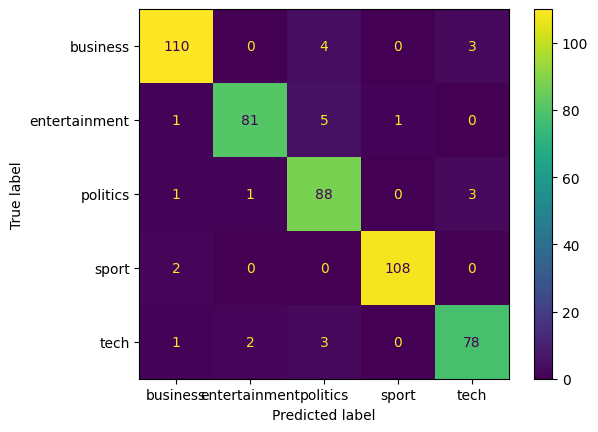

In [24]:
# Make predictions
predictions = knc.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knc.classes_)
disp.plot()

##### Classification report

In [25]:
print(classification_report(y_test, predictions))

               precision    recall  f1-score   support

     business       0.96      0.94      0.95       117
entertainment       0.96      0.92      0.94        88
     politics       0.88      0.95      0.91        93
        sport       0.99      0.98      0.99       110
         tech       0.93      0.93      0.93        84

     accuracy                           0.95       492
    macro avg       0.94      0.94      0.94       492
 weighted avg       0.95      0.95      0.95       492



##### Cross validation

In [26]:
# # Define the preprocessor pipeline
# preprocessor = make_pipeline(
#     CountVectorizer(), 
#     TfidfTransformer(),
#     StandardScaler(with_mean=False)  # Assuming you are using sparse matrices
# )

# # Preprocess the training data
# X_train_preprocessed = preprocessor.fit_transform(X)

# # Define k values
# k_values = list(range(1, 31))
# scores = []

# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     score = np.mean(cross_val_score(knn, X_train_preprocessed, y, cv=5))
#     scores.append(score)

# # Plot the results
# sns.lineplot(x=k_values, y=scores, marker='o')
# plt.xlabel("K Values")
# plt.ylabel("Accuracy Score")
# plt.title("Cross-Validation Accuracy for Different K Values")
# plt.show()

# CE CODE DURE 5MN. Une copie du graph est dans le repertoir image du rapport sous le nom `cross_validation_knc.png`

## Classification model (Doc2vec)

Doc2Vec is a Model that represents each Document as a Vector. It usually outperforms Word2Vec model.  
  
Corresponding research paper: https://cs.stanford.edu/~quocle/paragraph_vector.pdf

### Vectorization

Train the Doc2vec model

In [6]:
documents = df_train["Text"]

In [7]:
# Be careful: the words property should be a list of strings, not a string.
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(documents)]

# Training the Doc2Vec model
vector_size = 100
model = Doc2Vec(vector_size=vector_size, window=5, min_count=1, workers=4, epochs=10)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [10]:
model.infer_vector(X_train[0].split())

array([ 0.04762407,  0.7778431 ,  0.4126767 ,  0.57249004,  0.2090233 ,
       -0.11919945,  0.02293062,  0.15451717, -0.6662599 ,  0.39305347,
       -0.36832556, -0.14892654, -0.11104172,  0.16934837, -0.22984655,
        0.0884641 ,  0.21831606,  0.378946  , -0.09294733, -0.01789455,
        0.7139263 ,  0.39560968,  0.6095312 , -0.40486637,  0.3571761 ,
        0.27449194, -0.13226058, -0.2774223 , -0.88963413,  0.07586408,
        0.6277358 , -0.37301317,  0.18543738, -0.47047493,  0.33600822,
        0.2497556 ,  0.60725224, -0.12583868,  0.3156821 , -0.5573821 ,
        0.4381176 , -0.26052386, -1.3905146 , -0.75722337,  0.45495957,
        0.13405214, -0.07738148,  0.5625008 , -0.4332703 ,  0.47649917,
        0.3986952 ,  0.28135613, -0.12836899, -0.00807063, -0.33722535,
        0.360568  , -0.11995663, -0.56130576, -0.3927489 ,  0.28261974,
       -0.1863736 ,  0.19212346, -0.7014467 ,  0.09892001,  0.5842248 ,
        0.47795758,  0.8881936 ,  0.3240438 , -0.63922167,  0.96

Get vector for each document of the dataset

In [11]:
# Get vectors
X_train_vec = np.array([model.infer_vector(doc.split()) for doc in X_train])
X_test_vec = np.array([model.infer_vector(doc.split()) for doc in X_test])
X_train_vec

array([[ 0.04401391,  0.24956419,  0.33192405, ..., -0.5413645 ,
         0.29758358,  0.4255614 ],
       [-0.26685452,  0.31572005,  0.20848128, ..., -0.15837853,
        -0.32163125,  0.3877678 ],
       [ 0.08077954,  0.72926915, -0.18557623, ...,  0.18535002,
         0.6020867 , -0.43038318],
       ...,
       [ 0.07132628,  0.20458703, -0.14829981, ..., -0.17688115,
        -0.29692975,  0.15937792],
       [ 0.3644178 ,  0.5713975 ,  0.19839531, ..., -0.05178586,
         0.64830625, -0.43650496],
       [-0.01772329,  1.2252994 , -0.19706225, ..., -0.08835319,
        -0.3548652 , -0.03992995]], dtype=float32)

### SVC model

#### Training

In [12]:
svc = SVC(random_state=42)

svc.fit(X_train_vec, y_train)

SVC(random_state=42)

### Evaluation

Confusion matrix

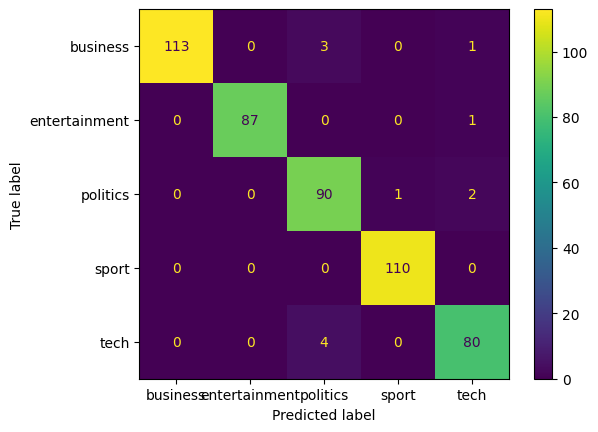

In [13]:
predictions = svc.predict(X_test_vec)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

Classification report

In [14]:
print(classification_report(y_test, predictions))

               precision    recall  f1-score   support

     business       1.00      0.97      0.98       117
entertainment       1.00      0.99      0.99        88
     politics       0.93      0.97      0.95        93
        sport       0.99      1.00      1.00       110
         tech       0.95      0.95      0.95        84

     accuracy                           0.98       492
    macro avg       0.97      0.97      0.97       492
 weighted avg       0.98      0.98      0.98       492



This model performs a little bit better with a Doc2Vec vectorization than with a CountVectorizer + TFIDF vectorization (results expected as Doc2Vec is supposed to be state of the art vectorization method).

### KNN model

#### Training

In [15]:
knn = KNeighborsClassifier()
knn.fit(X_train_vec, y_train)

KNeighborsClassifier()

#### Evaluation

Confusion matrix

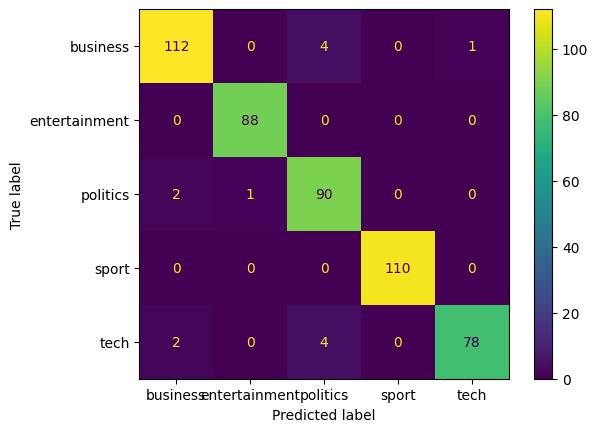

In [16]:
predictions = knn.predict(X_test_vec)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

Classification report

In [17]:
print(classification_report(y_test, predictions))

               precision    recall  f1-score   support

     business       0.97      0.96      0.96       117
entertainment       0.99      1.00      0.99        88
     politics       0.92      0.97      0.94        93
        sport       1.00      1.00      1.00       110
         tech       0.99      0.93      0.96        84

     accuracy                           0.97       492
    macro avg       0.97      0.97      0.97       492
 weighted avg       0.97      0.97      0.97       492



Here again, the model performs better using Doc2Vec vectorization.